# $\epsilon$-greedy

In [1]:
import jax
from jax import random
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import pandas as pd

In [3]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

## The 10-armed Testbed

In [52]:
key = random.PRNGKey(31415)

key_bandit, key_sample = random.split(key, 2)
n_bandits = 10
true_values = random.normal(key_bandit, (n_bandits,))
true_values

DeviceArray([ 0.09987481, -0.2125681 ,  1.4521614 , -0.8110563 ,
             -0.89297926,  0.61249924, -1.8329982 ,  0.21462014,
             -0.8210585 ,  0.38306195], dtype=float32)

In [53]:
n_samples = 5000
bandit_samples = random.normal(key_sample, (n_bandits, n_samples)) + true_values[:, None]
bandit_samples.shape

(10, 5000)

In [54]:
bandit_samples = pd.DataFrame(bandit_samples.T).melt()
bandit_samples = bandit_samples.rename({"variable":"action", "value":"reward"}, axis=1)

(-4.0, 4.0)

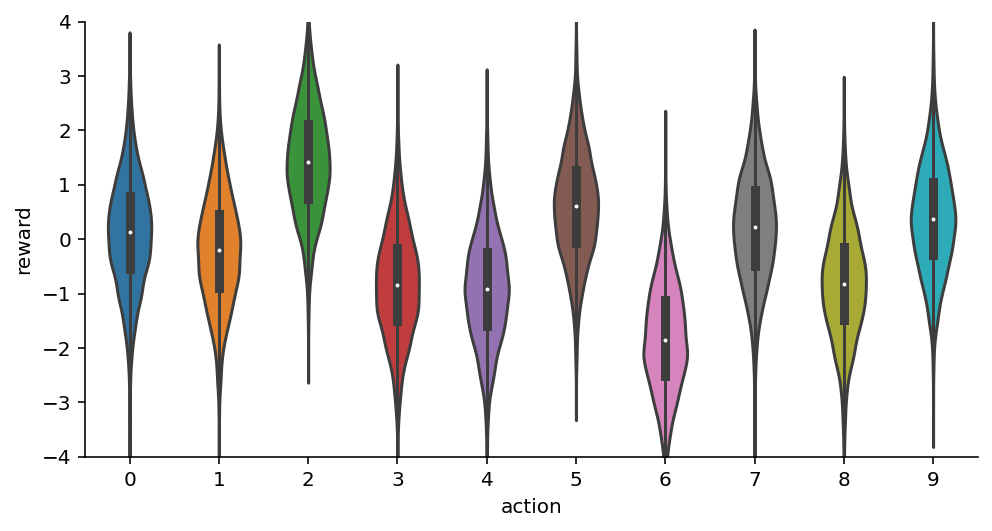

In [55]:
plt.subplots(figsize=(8, 4))
sns.violinplot(x="action", y="reward", data=bandit_samples, width=0.5)
plt.ylim(-4, 4)

## $\epsilon$-greedy method

$$
    Q_t(a) := \frac{\sum_{\tau=1}^{t-1} R_\tau \mathbb{1}(A_{\tau=a})}{\sum_{\tau=1}^{t-1} \mathbb{1}(A_{\tau=a})}
$$

In [56]:
num_steps = 1000
eps = 0.01
bandits = jnp.arange(n_bandits)
key_step = random.PRNGKey(3141)

In [277]:
def take_greedy(state, key, eps):
    num_visits, rewards = state
    key_action_random, key_action_greedy, key_reward, key_greedy = random.split(key, 4)
    
    Qt = rewards / jnp.clip(num_visits, 1)
    take_greedy = (jax.random.uniform(key_greedy) > eps) * 1.0
    
    map_choice = Qt.max() == Qt
    prob_choice_Q = map_choice / map_choice.sum()
    
    greedy_action = random.choice(key_action_greedy, bandits, p=prob_choice_Q)
    random_action = random.choice(key_action_random, bandits)
    
    action = take_greedy * greedy_action + (1 - take_greedy) * random_action
    reward = random.normal(key_reward) + true_values[action.astype(int)]
    
    action_ohe = jax.nn.one_hot(action, n_bandits)
    num_visits = num_visits + action_ohe
    rewards = rewards + action_ohe * reward
    
    return (num_visits, rewards), (reward, action)

In [278]:
key = random.PRNGKey(314159)
keys = random.split(key, num_steps)
num_visits = jnp.zeros(n_bandits)
rewards = jnp.zeros(n_bandits)

In [279]:
eps = 0.01

In [280]:
%%time
(num_visits_final, rewards_final), (rewards_samp, actions_samp) = jax.lax.scan(lambda state, key: take_greedy(state, key, eps), (num_visits, rewards), keys)

CPU times: user 1.79 s, sys: 81.3 ms, total: 1.87 s
Wall time: 1.75 s


In [281]:
eps_greedy_sims = jax.vmap(lambda key, eps: jax.lax.scan(lambda state, key: take_greedy(state, key, eps),
                                       (num_visits, rewards), random.split(key, num_steps)), in_axes=(0, None))

In [282]:
%%time
n_sims = 2000
keys = random.split(key, n_sims)
_, (reward_sims, action_sims) = eps_greedy_sims(keys, eps)

CPU times: user 2.51 s, sys: 185 ms, total: 2.69 s
Wall time: 1.62 s


In [283]:
num_visits.mean(axis=0)

DeviceArray(0., dtype=float32)

In [284]:
action_sims.mean(axis=0)[-20:].round()

DeviceArray([3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
             3., 3., 3., 3., 3.], dtype=float32)

In [285]:
true_values.max()

DeviceArray(1.4521614, dtype=float32)

In [286]:
reward_sims.mean(axis=0)[-20:]

DeviceArray([1.1982737, 1.2117828, 1.2023418, 1.1857393, 1.2188797,
             1.1732131, 1.2098577, 1.1789887, 1.1963278, 1.2202361,
             1.1741434, 1.2248776, 1.1951777, 1.2148211, 1.2321333,
             1.2049966, 1.2196025, 1.144635 , 1.2410688, 1.2444371],            dtype=float32)

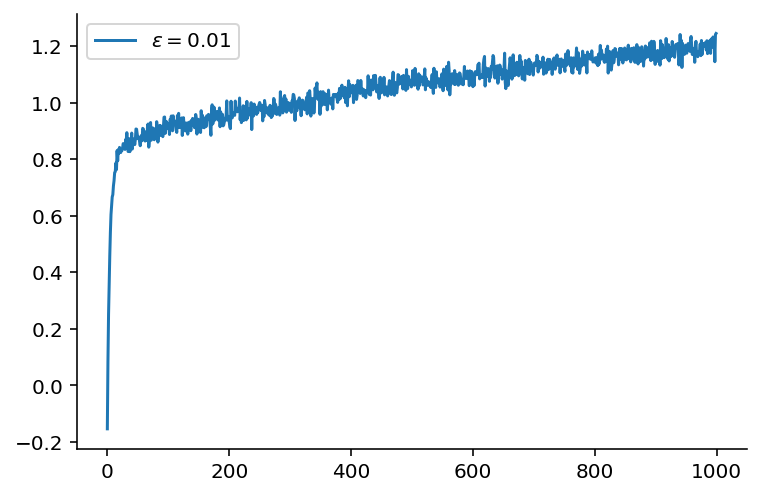

In [287]:
plt.plot(reward_sims.mean(axis=0), label="$\epsilon=$"f"{eps}")
plt.legend()

In [288]:
%%time
eps_greedy_sims_multiple = jax.vmap(eps_greedy_sims, in_axes=(None, 0))
eps_values = jnp.array([0., 0.01, 0.1, 0.7])
_, (reward_sims_multiple, action_sims_multiple) = eps_greedy_sims_multiple(keys, eps_values)

CPU times: user 2.87 s, sys: 49 ms, total: 2.92 s
Wall time: 1.6 s


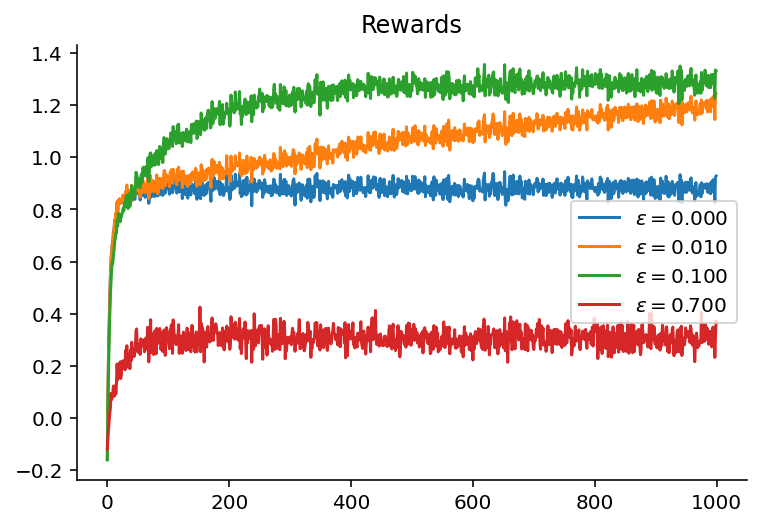

In [289]:
plt.plot(reward_sims_multiple.mean(axis=1).T)
legends = ["$\epsilon=$"f"{eps:0.3f}" for eps in eps_values]
plt.title("Rewards")
plt.legend(legends);

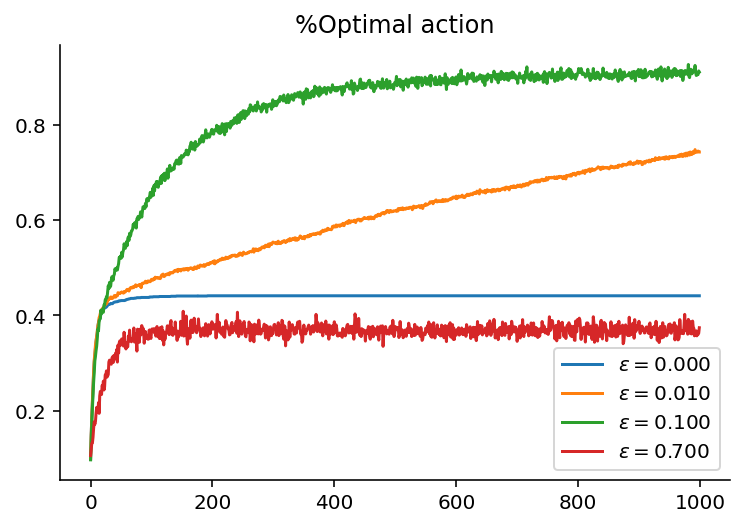

In [290]:
plt.title("%Optimal action")
plt.plot((action_sims_multiple == true_values.argmax()).mean(axis=1).T)
legends = ["$\epsilon=$"f"{eps:0.3f}" for eps in eps_values]
plt.legend(legends);